In [37]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate
import CoolProp
import CoolProp.CoolProp as CP
import pandas as pd

## Assumptions:

1. Constant liquid hold up on each plate 
2. Constant liquid flow in each of the three sections of the column
3. Constant vapour flow in the column
4. No vapour holdup in the column
5. Constant hold up in reboiler and condenser
6. Constant relative volatility

In [4]:
def rel_vol(xi):
    
    xi = np.asarray(xi)
    x= np.asarray([ 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943])
    y = np.asarray([ 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943])
    
    αi = (y*(1-x))/(x*(1-y))
    α = gmean(αi)
    xi = (α*xi)/(1+(α-1)*xi)
    
    return xi

In [5]:
def vle_data(xi):
    
    x_data = [0, 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943, 1]
    y_data = [0, 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943, 1]
    T_data = [100,95.5,89,86.7,85.3,84.1,82.7,82.3,81.5,80.7,79.8,79.7,79.3,
             78.74,78.41,78.15,78.30]
    x = np.interp(xi,x_data, y_data)
    T = np.interp(xi,x_data,T_data)
    return x,T

In [6]:
def feed_vector(plates,feedplate,feed,reflux,boilup):
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    feed_vec1 = np.zeros(plates)
    feed_vec2 = np.zeros(plates)
    flow_vec_top = np.zeros(plates)
    flow_vec_bot = np.zeros(plates)
    
    flow_vec_top[0:feedplate] = L1
    flow_vec_top[feedplate:] = L2
    
    flow_vec_bot[0:feedplate-1] = L1
    flow_vec_bot[feedplate-1:] = L2
    
    feed_vec1[feedplate-1] = feed
    feed_vec2[0] = R
    feed_vec2[-1] = BU
    
    return np.asarray([flow_vec_top,flow_vec_bot,feed_vec1,feed_vec2])

In [7]:
feed_vector(12,4,1,2,3)

NameError: name 'R_r' is not defined

In [8]:
def comp_vector(xi,yi):
    
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    xi1 = np.copy(xi)
    xi1 = np.roll(xi1, 1)
    xi1[0] = 0
    
    xi2 = np.copy(xi)
    xi2[-1] = 0
    
    yi1 = np.copy(yi)
    yi1 = np.roll(yi1, -1)
    yi1[-1] = 0
    
    yi2 = np.copy(yi)
    yi2[0] = 0
    
    
    return np.asarray([xi1,xi2]),np.asarray([yi1,yi2])

In [9]:
comp_vector([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

TypeError: comp_vector() missing 1 required positional argument: 'yi'

In [10]:
def holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl):
    holdup_vec = np.zeros(plates)
    
    holdup_vec[0] = m_cond
    holdup_vec[-1] = m_rebl
    holdup_vec[1:plates-1] = m_tray
    
    return holdup_vec

In [11]:
holdup_vector(12,4, 0.15, 0.2,0.45)

array([0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
       0.45])

In [25]:
def mass_DE(t, x):
    
    xi = np.asarray(x)
    yi,_ = vle_data(xi)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F, R, BU)
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates,feedplate, m_cond,m_tray,m_rebl)
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
                     
    return dxdt

In [26]:
# plates is the number of total plates + 2 (for the reboiler and condenser)
# feedplate is the plate number the feed occurs on
# x_initial is an array with the initial column states

plates = 12
feedplate = 4

## Inputs to calculate intial state

### Input variables

1. $F_3$ - Feed flow rate on plate 3
2. $F_7$ - Feed flow rate on plate 7
3. $x_F$ - Feed liquid composition
4. $Rr$ - Reflux ratio
5. $D_F$ - Distillate to feed ratio

### Parameters

1. $\alpha$ - Relative volatility
2. $m_{tray}$ - holdup on each tray
2. $m_{cond}$ - holdup in the total condenser
2. $m_{rebl}$ - holdup in the partial reboiler

In [59]:
init = [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
        0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]

F = 1 # Feed on plate 3
D =0.5
xF = 0.5 # mole fraction in feed
R_r = 0.9 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler

In [60]:
mass_DE(0,init)

array([-2.39573232e-08,  3.97217758e-02,  2.86033282e-02,  3.89790072e-02,
       -7.11441176e-06,  1.49798529e-05, -9.97433824e-05,  7.58691176e-06,
       -1.57357456e-03, -3.80074104e-03, -2.16375619e-02, -3.56212332e-02])

In [61]:
tspan = (0,50)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

In [62]:
x = initial_run.y
# xi = [x0s[-1],x1s[-1],x2s[-1],x3s[-1],x4s[-1],x5s[-1],x6s[-1],x7s[-1],x8s[-1],x9s[-1],x10s[-1],x11s[-1]]

[0.72817078 0.65672363 0.59258388 0.5287226  0.5287135  0.52860131
 0.52841301 0.52742821 0.52466436 0.51172982 0.46211432 0.27180352]


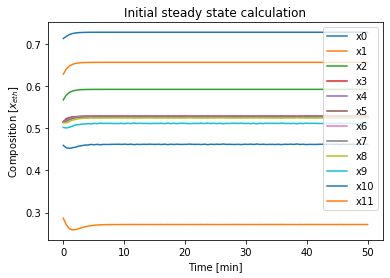

In [63]:
plt.figure(1)
plt.title("Initial steady state calculation")

for i in range(len(initial_run.y)) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

plt.savefig("Basic_distillation_column_V3.svg")
print(x[:,-1])

In [40]:
x_ss = [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
        0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]
y_ss,T_ss = vle_data(x_ss)
steady_state = pd.DataFrame({'x_ss':x_ss, 'y_ss':y_ss, 'T_ss':T_ss})
steady_state

,x_ss,y_ss,T_ss
0,0.713322,0.760954,78.567682
1,0.628582,0.713322,78.999183
2,0.567562,0.681545,79.342235
3,0.515591,0.658662,79.735373
4,0.515589,0.658661,79.735389
5,0.515574,0.658657,79.735517
6,0.515506,0.658637,79.736088
7,0.515082,0.658512,79.739651
8,0.512887,0.657867,79.758096
9,0.502318,0.654185,79.845100


In [42]:
init= [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
        0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]

In [43]:
mass_DE(0,init)

array([-2.01745879e-08,  3.09174580e-08, -1.52551223e-07,  1.16264706e-06,
       -5.22529412e-06,  1.85988235e-05, -5.71720588e-05,  1.73765294e-04,
       -4.58664101e-04,  9.71333860e-04, -1.37607317e-03,  3.52249230e-04])